In [3]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


Bad key savefig.frameon in file C:\WORK\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\WORK\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\WORK\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get an updated matplotlibrc file from
https://github

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error

class RandomForestMSE:
    def __init__(self, n_estimators, max_depth=None, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        
        self.n_estimators_ = n_estimators
        self.max_depth_ = max_depth
        if feature_subsample_size is None:
            self.feature_subsample_size_ = 1./3
        else:
            self.feature_subsample_size_ = feature_subsample_size
        
        self.trees_parameters_ = trees_parameters
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects

        X_val : numpy ndarray
            Array of size n_val_objects, n_features
            
        y_val : numpy ndarray
            Array of size n_val_objects           
       
        if X_val != None returns
        -------
        rmse : numpy ndarray
            Array of size n_estimators
        """
        
        n_features = int(self.feature_subsample_size_ * X.shape[1])
        self.trees_ = [DecisionTreeRegressor(max_depth=self.max_depth_, **self.trees_parameters_) 
                          for i in range(self.n_estimators_)]
        self.indices_ = np.zeros((self.n_estimators_, n_features), dtype=int)
        rmse = np.zeros(self.n_estimators_)
        val_pred_sum = 0
        
        for i in range(self.n_estimators_):
            self.indices_[i] = np.random.choice(X.shape[1], n_features, replace=False)
            
            self.trees_[i].fit(X[:, self.indices_[i]], y)
            
            if X_val is not None:
                val_pred_sum += self.trees_[i].predict(X_val[:, self.indices_[i]])
                rmse[i] = mean_squared_error(val_pred_sum/(i+1), y_val, squared=False)
        
        if X_val is not None:
            return rmse
        
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        
        answer = np.zeros(X.shape[0])
            
        for i in range(self.n_estimators_):
            answer += self.trees_[i].predict(X[:, self.indices_[i]])
        
        return answer/self.n_estimators_

In [82]:
class GradientBoostingMSE:
    def __init__(self, n_estimators, learning_rate=0.1, max_depth=5, feature_subsample_size=None,
                 **trees_parameters):
        """
        n_estimators : int
            The number of trees in the forest.
        
        learning_rate : float
            Use learning_rate * gamma instead of gamma
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        
        feature_subsample_size : float
            The size of feature set for each tree. If None then use recommendations.
        """
        self.n_estimators_ = n_estimators
        self.max_depth_ = max_depth
        self.learning_rate_ = learning_rate
        
        if feature_subsample_size is None:
            self.feature_subsample_size_ = 1./3
        else:
            self.feature_subsample_size_ = feature_subsample_size
        
        self.trees_parameters_ = trees_parameters
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        y : numpy ndarray
            Array of size n_objects
            
        X_val : numpy ndarray
            Array of size k_objects, n_features
            
        y_val : numpy ndarray
            Array of size k_objects
            
        if X_val != None returns
        -------
        rmse : numpy ndarray
            Array of size n_estimators
        """
        
        pred_y = np.zeros(X.shape[0])
        
        n_features = int(self.feature_subsample_size_ * X.shape[1])
        self.coefs_ = np.zeros(self.n_estimators_)
        self.trees_ = [DecisionTreeRegressor(max_depth=self.max_depth_, **self.trees_parameters_) 
                          for i in range(self.n_estimators_)]
        self.indices_ = np.zeros((self.n_estimators_, n_features), dtype=int)
        rmse = np.zeros(self.n_estimators_)
        val_pred_sum = 0
        
        for i in range(self.n_estimators_):
            grad = y - pred_y
            self.indices_[i] = np.random.choice(X.shape[1], n_features, replace=False)
            
            X_temp = X[:, self.indices_[i]]
            self.trees_[i].fit(X_temp, grad)
            
            tree_pred = self.trees_[i].predict(X_temp)
            self.coefs_[i] = minimize_scalar(lambda x: ((grad - x*tree_pred)**2).sum()).x
            pred_y += self.learning_rate_ * self.coefs_[i] * tree_pred
            
            if X_val is not None:
                val_pred_sum += self.trees_[i].predict(X_val[:, self.indices_[i]]) * self.coefs_[i]
                rmse[i] = mean_squared_error(val_pred_sum*self.learning_rate_, y_val, squared=False)
        
        if X_val is not None:
            return rmse
            
    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
            
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        answer = np.zeros(X.shape[0])
            
        for i in range(self.n_estimators_):
            answer += self.trees_[i].predict(X[:, self.indices_[i]]) * self.coefs_[i]
            
        answer *= self.learning_rate_
        
        return answer


# Обработка данных

In [4]:
data = pd.read_csv("train_data.csv", index_col = "index")
labels = pd.read_csv("train_target.csv", index_col = "index")

In [5]:
from datetime import datetime

data["year"] = data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').year)
data["month"] = data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').month)
data["day"] = data["date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').day)

data.drop("date", axis=1, inplace=True)

In [33]:
b.to_csv("b.csv", index=False)

In [26]:
labels

,Unnamed: 0,0
0,0,420.474279
1,1,351.472911
2,2,665.317791
3,3,615.121877
4,4,403.914597
...,...,...
17275,17275,308.130704
17276,17276,428.005137
17277,17277,253.183157
17278,17278,263.148807


In [10]:
data.to_csv("train_data_new.csv", index=False)
labels.to_csv("train_target_new.csv",index=False)

In [22]:
np.string("1.2 2 3 4", sep=" ")

AttributeError: module 'numpy' has no attribute 'string'

In [76]:
data = data.to_numpy()
labels = labels.to_numpy().ravel()

In [78]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

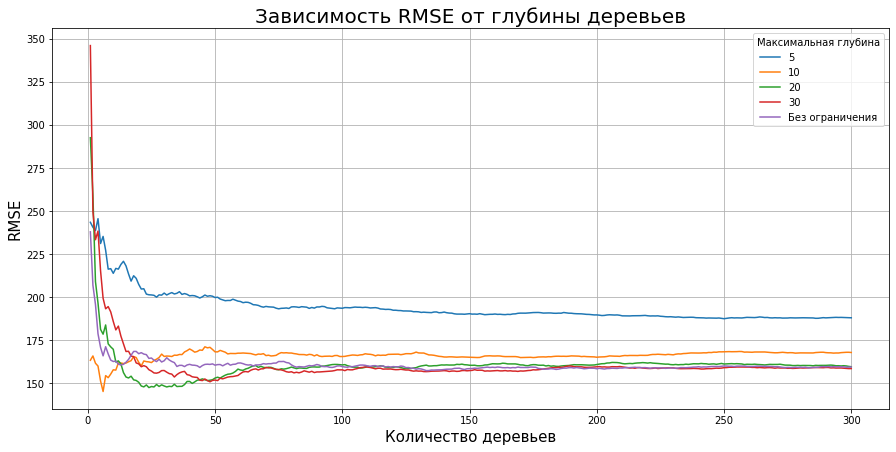

In [80]:
depth_list = [5, 10, 20, 30]
fig = plt.figure(figsize=(15, 7))

for max_depth in depth_list:
    reg = RandomForestMSE(300, max_depth=max_depth)
    rmse_list = reg.fit(X_train, y_train, X_test, y_test)
    plt.plot(range(1, 301), rmse_list, label=str(max_depth))

reg = RandomForestMSE(300)
rmse_list = reg.fit(X_train, y_train, X_test, y_test)
plt.plot(range(1, 301), rmse_list, label="Без ограничения")

plt.title("Зависимость RMSE от глубины деревьев", fontsize=20)
plt.grid()
plt.legend(title="Максимальная глубина")
plt.xlabel("Количество деревьев", fontsize=15)
plt.ylabel("RMSE", fontsize=15)

fig.savefig("RandForDepth.pdf")

Wall time: 6min 4s


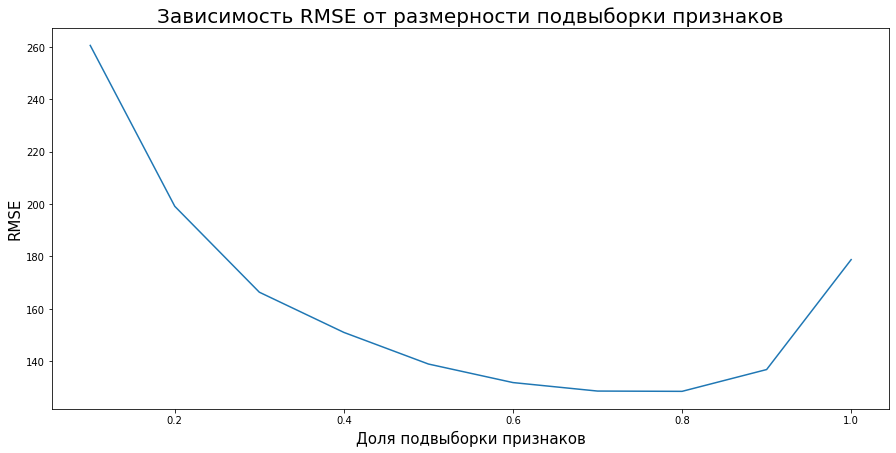

In [81]:
%%time
fig = plt.figure(figsize=(15, 7))
subsample_sizes = [0.1, 0.3, 0.6, 1]
rmse_list = []

for subsample_size in np.arange(0.1, 1.1, 0.1):
    reg = RandomForestMSE(300, max_depth=20, feature_subsample_size=subsample_size)
    reg.fit(X_train, y_train)
    pred_y = reg.predict(X_test)
    rmse_list.append(mean_squared_error(pred_y, y_test, squared=False))
    
plt.plot(np.arange(0.1, 1.1, 0.1), rmse_list)

plt.title("Зависимость RMSE от размерности подвыборки признаков", fontsize=20)
plt.grid()
plt.xlabel("Доля подвыборки признаков", fontsize=15)
plt.ylabel("RMSE", fontsize=15)

fig.savefig("RandForFeatSize.pdf")

Wall time: 1min 8s


<Figure size 1080x504 with 0 Axes>

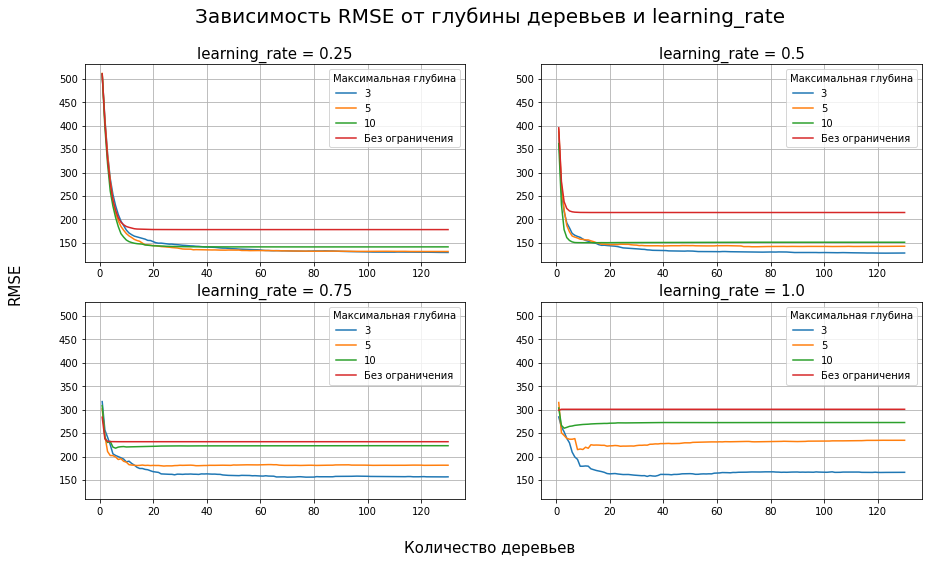

In [101]:
%%time
depth_list = [3, 5, 10, None]
fig = plt.figure(figsize=(15, 7))

fig, axes = plt.subplots(2, 2, sharey="all", figsize=(15, 8))

for i in range(2):
    for j in range(2):
        lr = 0.25*(2*i+j+1)
        
        for max_depth in depth_list:
            reg = GradientBoostingMSE(130, learning_rate=lr, max_depth=max_depth)
            rmse_list = reg.fit(X_train, y_train, X_test, y_test)
            label = "Без ограничения" if max_depth is None else str(max_depth)
            axes[i][j].plot(range(1, 131), rmse_list, label=label)
            
        axes[i][j].yaxis.set_tick_params(labelbottom=True)
        axes[i][j].legend(title="Максимальная глубина")
        axes[i][j].set_title("learning_rate = "+str(lr), fontsize=15)
        axes[i][j].grid()

fig.suptitle("Зависимость RMSE от глубины деревьев и learning_rate", fontsize=20)
plt.setp(axes, yticks=range(150, 550, 50))

fig.text(0.5, 0.04, 'Количество деревьев', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'RMSE', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig("BoostDepth.pdf")


Wall time: 1min 54s


<Figure size 1080x504 with 0 Axes>

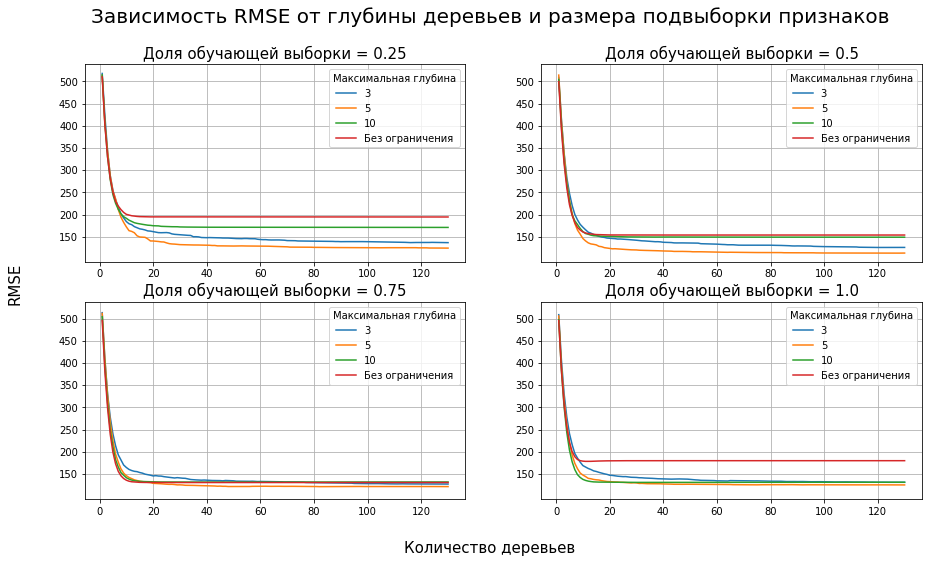

In [106]:
%%time
depth_list = [3, 5, 10, None]
fig = plt.figure(figsize=(15, 7))

fig, axes = plt.subplots(2, 2, sharey="all", figsize=(15, 8))

for i in range(2):
    for j in range(2):
        subsample_size = 0.25*(2*i+j+1)
        
        for max_depth in depth_list:
            reg = GradientBoostingMSE(130, learning_rate=0.25, max_depth=max_depth, 
                                      feature_subsample_size=subsample_size)
            rmse_list = reg.fit(X_train, y_train, X_test, y_test)
            label = "Без ограничения" if max_depth is None else str(max_depth)
            axes[i][j].plot(range(1, 131), rmse_list, label=label)
            
        axes[i][j].yaxis.set_tick_params(labelbottom=True)
        axes[i][j].legend(title="Максимальная глубина")
        axes[i][j].set_title("Доля обучающей выборки = "+str(subsample_size), fontsize=15)
        axes[i][j].grid()

fig.suptitle("Зависимость RMSE от глубины деревьев и размера подвыборки признаков", fontsize=20)
plt.setp(axes, yticks=range(150, 550, 50))

fig.text(0.5, 0.04, 'Количество деревьев', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'RMSE', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig("BoostFeatSize.pdf")


Wall time: 40.9 s


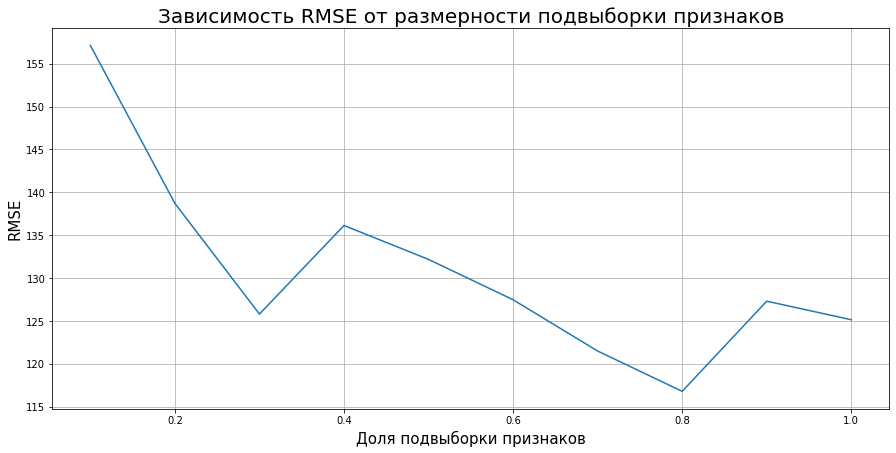

In [109]:
%%time
fig = plt.figure(figsize=(15, 7))
subsample_sizes = [0.1, 0.3, 0.6, 1]
rmse_list = []

for subsample_size in np.arange(0.1, 1.1, 0.1):
    reg = GradientBoostingMSE(150, max_depth=5, feature_subsample_size=subsample_size, learning_rate=0.25)
    reg.fit(X_train, y_train)
    pred_y = reg.predict(X_test)
    rmse_list.append(mean_squared_error(pred_y, y_test, squared=False))
    
plt.plot(np.arange(0.1, 1.1, 0.1), rmse_list)

plt.title("Зависимость RMSE от размерности подвыборки признаков", fontsize=20)
plt.grid()
plt.xlabel("Доля подвыборки признаков", fontsize=15)
plt.ylabel("RMSE", fontsize=15)

fig.savefig("BoostFeatSizeAlone.pdf")

In [23]:
np.arange(3)+1

array([1, 2, 3])